In [1]:
import matplotlib.pyplot as plt
import numpy as np

from common import NGSpiceRaw

%matplotlib widget

In [69]:
data = NGSpiceRaw("simulation/tgate_tb.raw", live=True)
print("Fields:", data.names)

Loaded 1 plots from simulation/tgate_tb.raw
Fields: ('time', 'v(vdd)', 'v(vss)', 'v(x1.ctrl_ni)', 'v(ctrl)', 'v(out_p)', 'v(x1.ctrl_i)', 'v(in_p)', 'v(x1.x2.net1)', 'v(x2.ctrl_ni)', 'v(out_n)', 'v(x2.ctrl_i)', 'v(in_n)', 'v(x2.x2.net1)', 'i(vin3)', 'i(vin2)', 'i(vin1)', 'i(vss)', 'i(vdd)', 'v(n.x2.xm4.nsg13_lv_pmos#NOI)', 'v(n.x2.xm4.nsg13_lv_pmos#GP)', 'v(n.x2.xm4.nsg13_lv_pmos#SI)', 'v(n.x2.xm4.nsg13_lv_pmos#DI)', 'v(n.x2.xm4.nsg13_lv_pmos#BP)', 'v(n.x2.xm4.nsg13_lv_pmos#BI)', 'v(n.x2.xm4.nsg13_lv_pmos#BS)', 'v(n.x2.xm4.nsg13_lv_pmos#BD)', 'v(n.x2.xm4.nsg13_lv_pmos#INT1)', 'v(n.x2.xm4.nsg13_lv_pmos#INT2)', 'v(n.x2.xm4.nsg13_lv_pmos#INT3)', 'v(n.x2.xm4.nsg13_lv_pmos#INT4)', 'v(n.x2.xm4.nsg13_lv_pmos#INT5)', 'v(n.x2.xm4.nsg13_lv_pmos#INT6)', 'v(n.x2.xm4.nsg13_lv_pmos#INT7)', 'v(n.x2.xm4.nsg13_lv_pmos#INT8)', 'v(n.x2.xm4.nsg13_lv_pmos#INT9)', 'v(n.x2.xm4.nsg13_lv_pmos#flow(RES1))', 'v(n.x2.xm4.nsg13_lv_pmos#flow(SPLINE1))', 'v(n.x2.xm4.nsg13_lv_pmos#flow(RES2))', 'v(n.x2.xm4.nsg13_lv_pm

In [70]:
F_SAMPLING = 80e6
N = 256
BASE_HARMONIC = 3
F_SIGNAL = F_SAMPLING / N * BASE_HARMONIC

In [71]:
times = data['time']
vin_n = data['v(in_n)']
vin_p = data['v(in_p)']
vout_n = data['v(out_n)']
vout_p = data['v(out_p)']

Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw


In [72]:
vin = vin_p - vin_n
vout = vout_p - vout_n

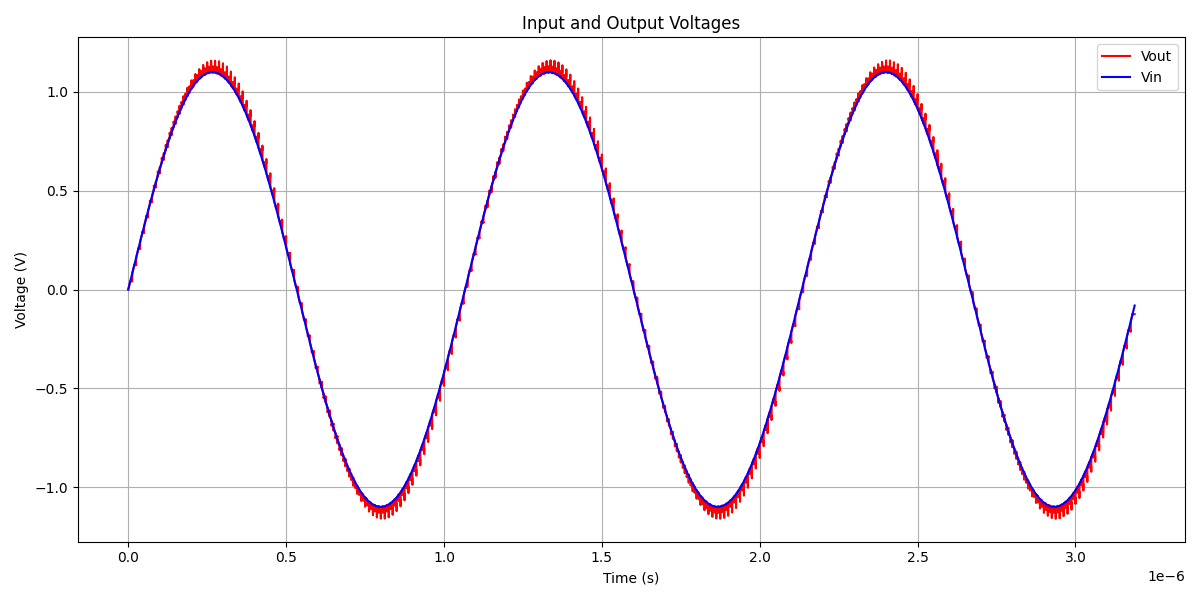

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(times, vout, label='Vout', color='red')
plt.plot(times, vin, label='Vin', color='blue')
plt.title('Input and Output Voltages')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Number of samples: 256
Frequency bin size: 312500.0


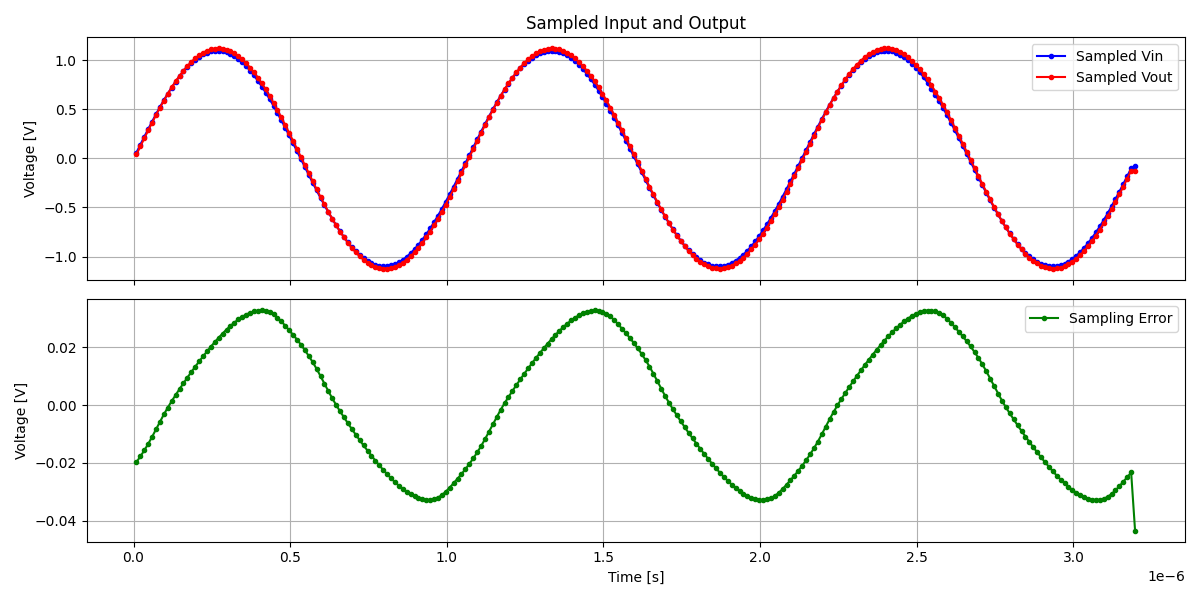

In [74]:
sampling_times = [0.75 / F_SAMPLING]
while sampling_times[-1] < times[-1]:
    sampling_times.append(sampling_times[-1] + 1 / F_SAMPLING)
# sampling_times = sampling_times[:-1]  # Remove the last time if it exceeds the signal duration

N = len(sampling_times)
f_bin = F_SAMPLING / N
print("Number of samples:", N)
print("Frequency bin size:", f_bin)

sampling_times = np.array(sampling_times)
sampling_vin = np.interp(sampling_times, times, vin)
sampling_vout = np.interp(sampling_times, times, vout)

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
# plt.plot(times, vout, label='Vout', color='red')
# plt.plot(times, vin, label='Vin', color='blue')
ax[0].plot(sampling_times, sampling_vin, label='Sampled Vin', color='blue', marker='o', markersize=3)
ax[0].plot(sampling_times, sampling_vout, label='Sampled Vout', color='red', marker='o', markersize=3)
ax[0].set_title('Sampled Input and Output')
ax[0].set_ylabel('Voltage [V]')
ax[0].grid()
ax[0].legend()
ax[1].plot(sampling_times, sampling_vout-sampling_vin, label='Sampling Error', color='green', marker='o', markersize=3)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Voltage [V]')
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()

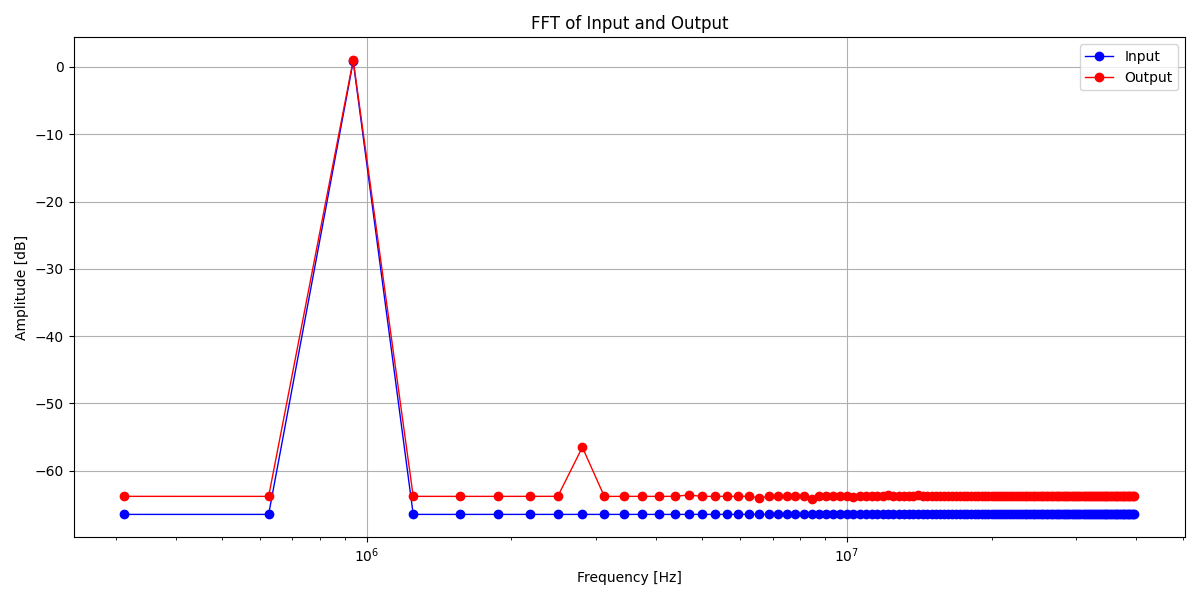

In [99]:
# FFT of input and output signals
N = len(sampling_vin)
T = 1 / F_SAMPLING

yf_vin = np.fft.fft(sampling_vin)
yf_vout = np.fft.fft(sampling_vout)
xf = np.fft.fftfreq(N, T)

yf_vin = 2.0 / N * np.abs(yf_vin[xf > 0])
yf_vout = 2.0 / N * np.abs(yf_vout[xf > 0])
xf = xf[xf > 0]

plt.figure(figsize=(12, 6))
plt.plot(xf, 20 * np.log10(yf_vin), 'o-', label='Input', color='blue', linewidth=1)
plt.plot(xf, 20 * np.log10(yf_vout), 'o-', label='Output', color='red', linewidth=1)
plt.title('FFT of Input and Output')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
# plt.xlim(0, 1.5 * F_SIGNAL)
plt.xscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [126]:
def compute_thd(signal, fundamental_index, max_harmonics=10):
    """
    Compute THD considering only actual harmonics (2f, 3f, 4f, etc.)
    """
    N = len(signal)
    yf = np.fft.fft(signal)
    
    # Fundamental amplitude
    fundamental_amplitude = np.abs(yf[fundamental_index])
    
    # Sum only the actual harmonics up to max_harmonics
    harmonics_amplitude = 0
    for h in range(2, max_harmonics + 1):
        harmonic_index = h * fundamental_index
        if harmonic_index < N // 2:  # Stay within Nyquist limit
            harmonics_amplitude += np.abs(yf[harmonic_index])
    
    thd = harmonics_amplitude / fundamental_amplitude
    return thd

def compute_snr(signal, fundamental_index, max_harmonics=10):
    """
    Compute SNR where noise excludes fundamental (and harmonics)
    """
    N = len(signal)
    yf = np.fft.fft(signal)
    
    # Signal power (fundamental only)
    signal_power = np.abs(yf[fundamental_index]) ** 2
    
    # Total power
    total_power = np.sum(np.abs(yf[:N//2]) ** 2)  # Only positive frequencies
    
    # Subtract fundamental and harmonics from total power to get noise
    harmonic_power = signal_power  # Start with fundamental
    # for h in range(2, max_harmonics + 1):
    #     harmonic_index = h * fundamental_index
    #     if harmonic_index < N // 2:
    #         harmonic_power += np.abs(yf[harmonic_index]) ** 2
    
    noise_power = total_power - harmonic_power
    
    if noise_power <= 0:
        return float('inf')  # Perfect signal
    
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

thd_vin = compute_thd(sampling_vin, BASE_HARMONIC)
thd_vout = compute_thd(sampling_vout, BASE_HARMONIC)

snr_vin = compute_snr(sampling_vin, BASE_HARMONIC)
snr_vout = compute_snr(sampling_vout, BASE_HARMONIC)

print("\tTHD\tSNR")
print(f"Vin:\t{thd_vin:.2%}\t{snr_vin:.1f} dB")
print(f"Vout:\t{thd_vout:.2%}\t{snr_vout:.1f} dB")

	THD	SNR
Vin:	0.39%	46.3 dB
Vout:	0.59%	43.6 dB
